In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
%matplotlib inline

from time_tools import sectoyear, nonzero_frequencies, period_to_freqindex
from fourier_tools import transform_forcing, split_NH_SH
from macmodes import Param
from forced_waves import forced_MAC_wave_spectrum

%load_ext autoreload
%autoreload 2

The goal of this notebook is to solve for the forced MAC wave problem, with a set of forcings extracted from the dynamo model Calypso.
The dimensional equation reads:

$$\begin{array}{rcl}
\partial_y^2 \tilde b_\theta'' + \displaystyle\left( \frac{C^2y^2 + mC}{M(1-y^2)} - \frac{m^2-1}{(1-y^2)^2}\right)\tilde b_\theta'' &=& 
\displaystyle\frac{m^2}{M(1-y^2)} A\tilde F_\theta \\
&&- i\displaystyle\left(\left(\frac{C}{M} + \frac{2}{m}\right)y 
+\frac{m\partial_y((1-y^2)^{\frac{1}{2}}\; \cdot )}{M(1-y^2)^{\frac{1}{2}}}\right)A\tilde F_\lambda \\
&&+ \displaystyle\left(\left(\frac{mC}{M} + 2 \right)\frac{y}{(1-y^2)^{\frac{1}{2}}} - (1-y^2)^{\frac{1}{2}}\partial_y\right)\dfrac{A}{Rk}\tilde F_r\\
&&+\displaystyle\frac{1}{\chi}\left(\partial_y^2 + \frac{C^2y^2 + mC}{M(1-y^2)} + (1-y^2)^{-2}\right)\frac{\tilde F_{I\theta}''}{-i\omega}\\
&&-\displaystyle\frac{i}{\chi}\left((1-y^2)^{\frac{1}{2}}\left(m\partial_y+Cy\right)- \frac{2my}{(1-y^2)^{\frac{1}{2}}}\right)\frac{\tilde F_{I\lambda}'}{-i\omega},
\end{array}$$

where $y$ is the cosine of latitude, $\tilde b_\theta''$ is the transformed $\theta$-component of the magnetic perturbation (in Fourier space), and $\tilde F_\theta$, $\tilde F_\lambda$, $\tilde F_r$, $\tilde F_{I\theta}''$ and $\tilde F_{I\lambda}''$ are the various forcing components (some are transformed). 

Upon discretization on a grid $(y_1,\dots,y_n)$, the problem reads

\begin{equation}
\begin{bmatrix}
0_n & I_n\\
-\textrm{diag}\left(\frac{M(1-y^2)}{y^2}\right)D_y^2 + \textrm{diag}\left(\frac{M(m^2-1)}{y^2(1-y^2)}\right) & -\textrm{diag}\left(\frac{m}{y^2}\right)
\end{bmatrix}
\begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix}
- C \begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix} = 
\begin{bmatrix}0_n \\ -\frac{M(1-y^2)}{y^2}\text{RHS}\end{bmatrix}
\end{equation}

where $\mathbf{x}_1$ is the discretized $\tilde b_\theta''$. $\textrm{diag}\left(\frac{m}{y^2}\right)$ denotes a matrix whose diagonal elements are $\frac{m}{y_1^2},\dots,\frac{m}{y_n^2}$, and similarly for other expressions. $D_y^2$ denotes a matrix of second differentiation on the grid. RHS denotes the right-hand-side of the forced problem above.

We will denote by $\mathbf{A}$ the first matrix of this discretized equation.

We also note (see section 3 of the Nicolas & Buffett 2023) that $F_{I\theta} = -i\omega B_{I\theta}$, hence the $\frac{\tilde F_{I\theta}''}{-i\omega}$ that appears in the forcing term is exactly $\tilde B_{I\theta}''$ (and similarly for the zonal term). This is reflected in the code.


# Dimensionalizing and extrapolating forcing terms

In [2]:
###### REALISTIC DIMENSIONAL PARAMETERS #######
param = Param(3,                   # angular order
              140e3,               # Stratified layer thickness
              0.5 * 2*np.pi/86400, # Buoyancy frequency = 0.5*Omega
              0.5e-3               # Background radial magnetic field in T
             )

## Control run

Calypso uses a classic viscous dimensionalization where velocities are scaled by $\nu/L$, time by $L^2/\nu$, and magnetic field by $\sqrt{\rho_0\mu\Omega\eta}$. Hence, we need to convert forcings to the diffusion-free scales used in the paper. Also, the zonal component of the Lorentz force and magnetic field are stored as 'phi' - in the rest of the notebook, we use 'lambda' to be consistent with the paper.

In [3]:
########## EXTRACTING & CONVERTING TO DIFFUSION-FREE SCALES ##########

### Buoyancy force ###
temperature_y_nd = xr.open_dataset("data/temperature_y300.nc")
temperature_y_nd=temperature_y_nd.temperature_real+1j*temperature_y_nd.temperature_imag
# Convert magnitude to diffusion-free scales
temperature_y_nd *= 1

### Lorentz force ###
lorentz_y_nd       = xr.open_dataset("data/Lorentz_force_y300.nc")
lorentz_theta_y_nd = lorentz_y_nd.Lorentz_force_theta_real+1j*lorentz_y_nd.Lorentz_force_theta_imag
lorentz_lambda_y_nd   = lorentz_y_nd.Lorentz_force_phi_real+1j*lorentz_y_nd.Lorentz_force_phi_imag
lorentz_r_y_nd     = lorentz_y_nd.Lorentz_force_r_real+1j*lorentz_y_nd.Lorentz_force_r_imag
# Convert magnitude to diffusion-free scales
E_sim=1e-5
lorentz_theta_y_nd*= E_sim**2
lorentz_lambda_y_nd  *= E_sim**2
lorentz_r_y_nd    *= E_sim**2

### Induction ###
B_y_nd= xr.open_dataset("data/magnetic_field_y300.nc")
B_theta_y_nd = B_y_nd.magnetic_field_theta_real+1j*B_y_nd.magnetic_field_theta_imag
B_lambda_y_nd   = B_y_nd.magnetic_field_phi_real+1j*B_y_nd.magnetic_field_phi_imag
# Convert magnitude to diffusion-free scales
E_sim=1e-5
Pm_sim=0.5
B_theta_y_nd*= np.sqrt(E_sim/Pm_sim)
B_lambda_y_nd  *= np.sqrt(E_sim/Pm_sim)

Once we have the nondimensional forcings in the right form, we need to extrapolate them to Earth-like conditions (see paper).

In [4]:
########## DIMENSIONALIZING ##########
Rastar_calypso = 3200
Omega_adjusted = 4.4e-8 #s^-1
alphaT = 1e-5           #K^-1
gR = 10.7               #m s^-2

### Buoyancy force ###
DeltaT_calypso = Rastar_calypso*Omega_adjusted**2*param.L / (alphaT*gR)
DeltaT_true = 10e-3  #K

buoyancy_y = (DeltaT_true/DeltaT_calypso) * alphaT*DeltaT_calypso*gR*temperature_y_nd  #Computing DeltaT_calypso was not needed but I've layed out the approach presented in the paper
buoyancy_y.attrs['unit'] = 'm s-2'

### Lorentz force & induction ###
Brms_calypso = 0.078e-3
Brms_true = 4e-3

lorentz_theta_y = (Brms_true**2/Brms_calypso**2) * Omega_adjusted**2*param.L * lorentz_theta_y_nd
lorentz_lambda_y   = (Brms_true**2/Brms_calypso**2) * Omega_adjusted**2*param.L * lorentz_lambda_y_nd  
lorentz_r_y     = (Brms_true**2/Brms_calypso**2) * Omega_adjusted**2*param.L * lorentz_r_y_nd    
lorentz_theta_y.attrs['unit'] = 'm s-2'
lorentz_lambda_y.attrs['unit'] = 'm s-2'
lorentz_r_y.attrs['unit'] = 'm s-2'

B_theta_y = (Brms_true/Brms_calypso) * np.sqrt(param.rho0*param.mu0)*Omega_adjusted*param.L * B_theta_y_nd
B_lambda_y   = (Brms_true/Brms_calypso) * np.sqrt(param.rho0*param.mu0)*Omega_adjusted*param.L * B_lambda_y_nd  
B_theta_y.attrs['unit'] = 'T'
B_lambda_y.attrs['unit'] = 'T'

We now Fourier transform the forcings in time and radius, and split the northern hemisphere and southern hemisphere parts (they will be used to force waves separately, then statistics are collected using both).

In [5]:
%%time
# radmin is the radius at the base of the stratified layer in Calypso.
buoyancy_y_tilda_NH,buoyancy_y_tilda_SH = split_NH_SH(transform_forcing(buoyancy_y,'sin',radmin = 1.41))

lorentz_theta_y_tilda_NH,lorentz_theta_y_tilda_SH = split_NH_SH(transform_forcing(lorentz_theta_y,'cos',radmin = 1.41))
lorentz_lambda_y_tilda_NH  ,lorentz_lambda_y_tilda_SH   = split_NH_SH(transform_forcing(lorentz_lambda_y,'cos',radmin = 1.41))
lorentz_r_y_tilda_NH    ,lorentz_r_y_tilda_SH     = split_NH_SH(transform_forcing(lorentz_r_y,'sin',radmin = 1.41))

B_theta_y_tilda_NH,B_theta_y_tilda_SH = split_NH_SH(transform_forcing(B_theta_y,'sin',radmin = 1.41))
B_lambda_y_tilda_NH  ,B_lambda_y_tilda_SH   = split_NH_SH(transform_forcing(B_lambda_y  ,'sin',radmin = 1.41))


CPU times: user 37 s, sys: 46.4 s, total: 1min 23s
Wall time: 2min 5s


In [6]:
# Sample forcing object (xarray.Dataset) that will be populated with different components in the following parts of the code
zeroforcing = buoyancy_y_tilda_NH.to_dataset(name='Fr')
for name in ['Fr','Ftheta','Flambda','FItheta','FIlambda']:
    zeroforcing[name] = 0*zeroforcing['Fr']

## Pm=2 run

In [9]:
########## EXTRACTING & CONVERTING TO DIFFUSION-FREE SCALES ##########

temperature_Pm2_y_nd = xr.open_dataset("data/temperature_Pm2_y300.nc")
temperature_Pm2_y_nd=temperature_Pm2_y_nd.temperature_real+1j*temperature_Pm2_y_nd.temperature_imag
# Convert magnitude to diffusion-free scales
temperature_Pm2_y_nd *= 1

lorentz_Pm2_y_nd       = xr.open_dataset("data/Lorentz_force_Pm2_y300.nc")
lorentz_Pm2_theta_y_nd = lorentz_Pm2_y_nd.Lorentz_force_theta_real+1j*lorentz_Pm2_y_nd.Lorentz_force_theta_imag
lorentz_Pm2_lambda_y_nd   = lorentz_Pm2_y_nd.Lorentz_force_phi_real+1j*lorentz_Pm2_y_nd.Lorentz_force_phi_imag
lorentz_Pm2_r_y_nd     = lorentz_Pm2_y_nd.Lorentz_force_r_real+1j*lorentz_Pm2_y_nd.Lorentz_force_r_imag
# Convert magnitude to diffusion-free scales
E_sim=1e-5
lorentz_Pm2_theta_y_nd*= E_sim**2
lorentz_Pm2_lambda_y_nd  *= E_sim**2
lorentz_Pm2_r_y_nd    *= E_sim**2

B_Pm2_y_nd= xr.open_dataset("data/magnetic_field_Pm2_y300.nc")
B_Pm2_theta_y_nd = B_Pm2_y_nd.magnetic_field_theta_real+1j*B_Pm2_y_nd.magnetic_field_theta_imag
B_Pm2_lambda_y_nd   = B_Pm2_y_nd.magnetic_field_phi_real+1j*B_Pm2_y_nd.magnetic_field_phi_imag
# Convert magnitude to diffusion-free scales
E_sim=1e-5
Pm2_sim=2.
B_Pm2_theta_y_nd*= np.sqrt(E_sim/Pm2_sim)
B_Pm2_lambda_y_nd  *= np.sqrt(E_sim/Pm2_sim)

In [10]:
########## DIMENSIONALIZING ##########
Rastar_calypso = 3200
Omega_adjusted = 4.4e-8 #s^-1
alphaT = 1e-5           #K^-1
gR = 10.7               #m s^-2

DeltaT_calypso = Rastar_calypso*Omega_adjusted**2*param.L / (alphaT*gR)
DeltaT_true = 10e-3  #K

buoyancy_Pm2_y = (DeltaT_true/DeltaT_calypso) * alphaT*DeltaT_calypso*gR*temperature_Pm2_y_nd  #Computing DeltaT_calypso was not needed but I've layed out the approach presented in the paper
buoyancy_Pm2_y.attrs['unit'] = 'm s-2'

Brms_calypso = 0.093e-3
Brms_true = 4e-3

lorentz_Pm2_theta_y = (Brms_true**2/Brms_calypso**2) * Omega_adjusted**2*param.L * lorentz_Pm2_theta_y_nd
lorentz_Pm2_lambda_y   = (Brms_true**2/Brms_calypso**2) * Omega_adjusted**2*param.L * lorentz_Pm2_lambda_y_nd  
lorentz_Pm2_r_y     = (Brms_true**2/Brms_calypso**2) * Omega_adjusted**2*param.L * lorentz_Pm2_r_y_nd    
lorentz_Pm2_theta_y.attrs['unit'] = 'm s-2'
lorentz_Pm2_lambda_y.attrs['unit'] = 'm s-2'
lorentz_Pm2_r_y.attrs['unit'] = 'm s-2'

B_Pm2_theta_y = (Brms_true/Brms_calypso) * np.sqrt(param.rho0*param.mu0)*Omega_adjusted*param.L * B_Pm2_theta_y_nd
B_Pm2_lambda_y   = (Brms_true/Brms_calypso) * np.sqrt(param.rho0*param.mu0)*Omega_adjusted*param.L * B_Pm2_lambda_y_nd  
B_Pm2_theta_y.attrs['unit'] = 'T'
B_Pm2_lambda_y.attrs['unit'] = 'T'

In [ ]:
%%time
buoyancy_Pm2_y_tilda_NH,buoyancy_Pm2_y_tilda_SH = split_NH_SH(transform_forcing(buoyancy_Pm2_y,'sin',radmin = 1.41))

lorentz_Pm2_theta_y_tilda_NH,lorentz_Pm2_theta_y_tilda_SH = split_NH_SH(transform_forcing(lorentz_Pm2_theta_y,'cos',radmin = 1.41))
lorentz_Pm2_lambda_y_tilda_NH  ,lorentz_Pm2_lambda_y_tilda_SH   = split_NH_SH(transform_forcing(lorentz_Pm2_lambda_y,'cos',radmin = 1.41))
lorentz_Pm2_r_y_tilda_NH    ,lorentz_Pm2_r_y_tilda_SH     = split_NH_SH(transform_forcing(lorentz_Pm2_r_y,'sin',radmin = 1.41))

B_Pm2_theta_y_tilda_NH,B_Pm2_theta_y_tilda_SH = split_NH_SH(transform_forcing(B_Pm2_theta_y,'sin',radmin = 1.41))
B_Pm2_lambda_y_tilda_NH  ,B_Pm2_lambda_y_tilda_SH   = split_NH_SH(transform_forcing(B_Pm2_lambda_y  ,'sin',radmin = 1.41))


CPU times: user 36.5 s, sys: 47.7 s, total: 1min 24s
Wall time: 2min 10s


# Spectrum & RMS figure

## Computing forced waves with forcings from the control run

In [ ]:
buoyancy_NH = zeroforcing.copy(); buoyancy_NH['Fr'] = buoyancy_y_tilda_NH
buoyancy_SH = zeroforcing.copy(); buoyancy_SH['Fr'] = buoyancy_y_tilda_SH

In [ ]:
%time by_rms_buoyancy_j1,by_powspec_buoyancy_j1_hlat = forced_MAC_wave_spectrum(param,buoyancy_NH,buoyancy_SH,jmax=1,nmodes='all')


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 50.3 s, sys: 4.63 s, total: 54.9 s
Wall time: 22.1 s


In [ ]:
lorentz_r_NH = zeroforcing.copy(); lorentz_r_NH['Fr'] = lorentz_r_y_tilda_NH
lorentz_r_SH = zeroforcing.copy(); lorentz_r_SH['Fr'] = lorentz_r_y_tilda_SH
lorentz_theta_NH = zeroforcing.copy(); lorentz_theta_NH['Ftheta'] = lorentz_theta_y_tilda_NH
lorentz_theta_SH = zeroforcing.copy(); lorentz_theta_SH['Ftheta'] = lorentz_theta_y_tilda_SH
lorentz_lambda_NH = zeroforcing.copy(); lorentz_lambda_NH['Flambda'] = lorentz_lambda_y_tilda_NH
lorentz_lambda_SH = zeroforcing.copy(); lorentz_lambda_SH['Flambda'] = lorentz_lambda_y_tilda_SH

In [ ]:
%time by_rms_lorentz_r_j1     , by_powspec_lorentz_r_j1_hlat      = forced_MAC_wave_spectrum(param,lorentz_r_NH,lorentz_r_SH,jmax=1,nmodes='all')
%time by_rms_lorentz_theta_j1 , by_powspec_lorentz_theta_j1_hlat  = forced_MAC_wave_spectrum(param,lorentz_theta_NH,lorentz_theta_SH,jmax=1,nmodes='all')
%time by_rms_lorentz_lambda_j1, by_powspec_lorentz_lambda_j1_hlat = forced_MAC_wave_spectrum(param,lorentz_lambda_NH,lorentz_lambda_SH,jmax=1,nmodes='all')


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 49.9 s, sys: 4.04 s, total: 53.9 s
Wall time: 18 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51.6 s, sys: 3.86 s, total: 55.4 s
Wall time: 18.1 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 50.7 s, sys: 3.77 s, total: 54.5 s
Wall time: 16.9 s


In [ ]:
B_theta_NH = zeroforcing.copy(); B_theta_NH['FItheta'] = B_theta_y_tilda_NH
B_theta_SH = zeroforcing.copy(); B_theta_SH['FItheta'] = B_theta_y_tilda_SH
B_lambda_NH = zeroforcing.copy(); B_lambda_NH['FIlambda'] = B_lambda_y_tilda_NH
B_lambda_SH = zeroforcing.copy(); B_lambda_SH['FIlambda'] = B_lambda_y_tilda_SH

In [ ]:
%time by_rms_induction_theta_j1 ,by_powspec_induction_theta_j1_hlat  = forced_MAC_wave_spectrum(param,B_theta_NH,B_theta_SH,jmax=1,nmodes='all')
%time by_rms_induction_lambda_j1,by_powspec_induction_lambda_j1_hlat = forced_MAC_wave_spectrum(param,B_lambda_NH,B_lambda_SH,jmax=1,nmodes='all')


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51 s, sys: 3.14 s, total: 54.1 s
Wall time: 16 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51.2 s, sys: 3.68 s, total: 54.9 s
Wall time: 18.2 s


## Computing forced waves with forcings from the Pm=2 run

In [ ]:
buoyancy_Pm2_NH = zeroforcing.copy(); buoyancy_Pm2_NH['Fr'] = buoyancy_Pm2_y_tilda_NH
buoyancy_Pm2_SH = zeroforcing.copy(); buoyancy_Pm2_SH['Fr'] = buoyancy_Pm2_y_tilda_SH

In [ ]:
%time by_rms_buoyancy_Pm2_j1,by_powspec_buoyancy_Pm2_j1_hlat = forced_MAC_wave_spectrum(param,buoyancy_Pm2_NH,buoyancy_Pm2_SH,jmax=1,nmodes='all')


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51.8 s, sys: 3.65 s, total: 55.4 s
Wall time: 17.5 s


In [ ]:
lorentz_Pm2_r_NH = zeroforcing.copy(); lorentz_Pm2_r_NH['Fr'] = lorentz_Pm2_r_y_tilda_NH
lorentz_Pm2_r_SH = zeroforcing.copy(); lorentz_Pm2_r_SH['Fr'] = lorentz_Pm2_r_y_tilda_SH
lorentz_Pm2_theta_NH = zeroforcing.copy(); lorentz_Pm2_theta_NH['Ftheta'] = lorentz_Pm2_theta_y_tilda_NH
lorentz_Pm2_theta_SH = zeroforcing.copy(); lorentz_Pm2_theta_SH['Ftheta'] = lorentz_Pm2_theta_y_tilda_SH
lorentz_Pm2_lambda_NH = zeroforcing.copy(); lorentz_Pm2_lambda_NH['Flambda'] = lorentz_Pm2_lambda_y_tilda_NH
lorentz_Pm2_lambda_SH = zeroforcing.copy(); lorentz_Pm2_lambda_SH['Flambda'] = lorentz_Pm2_lambda_y_tilda_SH

In [21]:
%time by_rms_lorentz_Pm2_r_j1     ,by_powspec_lorentz_Pm2_r_j1_hlat      = forced_MAC_wave_spectrum(param,lorentz_Pm2_r_NH,lorentz_Pm2_r_SH,jmax=1,nmodes='all')
%time by_rms_lorentz_Pm2_theta_j1 ,by_powspec_lorentz_Pm2_theta_j1_hlat  = forced_MAC_wave_spectrum(param,lorentz_Pm2_theta_NH,lorentz_Pm2_theta_SH,jmax=1,nmodes='all')
%time by_rms_lorentz_Pm2_lambda_j1,by_powspec_lorentz_Pm2_lambda_j1_hlat = forced_MAC_wave_spectrum(param,lorentz_Pm2_lambda_NH,lorentz_Pm2_lambda_SH,jmax=1,nmodes='all')


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 52.1 s, sys: 3.59 s, total: 55.7 s
Wall time: 16.5 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 52 s, sys: 4.29 s, total: 56.3 s
Wall time: 18.4 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 51.1 s, sys: 3.63 s, total: 54.7 s
Wall time: 18.1 s


In [22]:
B_Pm2_theta_NH = zeroforcing.copy(); B_Pm2_theta_NH['FItheta']  = B_Pm2_theta_y_tilda_NH
B_Pm2_theta_SH = zeroforcing.copy(); B_Pm2_theta_SH['FItheta']  = B_Pm2_theta_y_tilda_SH
B_Pm2_lambda_NH = zeroforcing.copy(); B_Pm2_lambda_NH['FIlambda'] = B_Pm2_lambda_y_tilda_NH
B_Pm2_lambda_SH = zeroforcing.copy(); B_Pm2_lambda_SH['FIlambda'] = B_Pm2_lambda_y_tilda_SH

In [23]:
%time by_rms_induction_Pm2_theta_j1 ,by_powspec_induction_Pm2_theta_j1_hlat  = forced_MAC_wave_spectrum(param,B_Pm2_theta_NH,B_Pm2_theta_SH,jmax=1,nmodes='all')
%time by_rms_induction_Pm2_lambda_j1,by_powspec_induction_Pm2_lambda_j1_hlat = forced_MAC_wave_spectrum(param,B_Pm2_lambda_NH,B_Pm2_lambda_SH,jmax=1,nmodes='all')


Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 49.8 s, sys: 3.71 s, total: 53.5 s
Wall time: 17.9 s
Number of frequencies treated (799 total):  0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 50.6 s, sys: 3.74 s, total: 54.4 s
Wall time: 17.2 s


## Figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

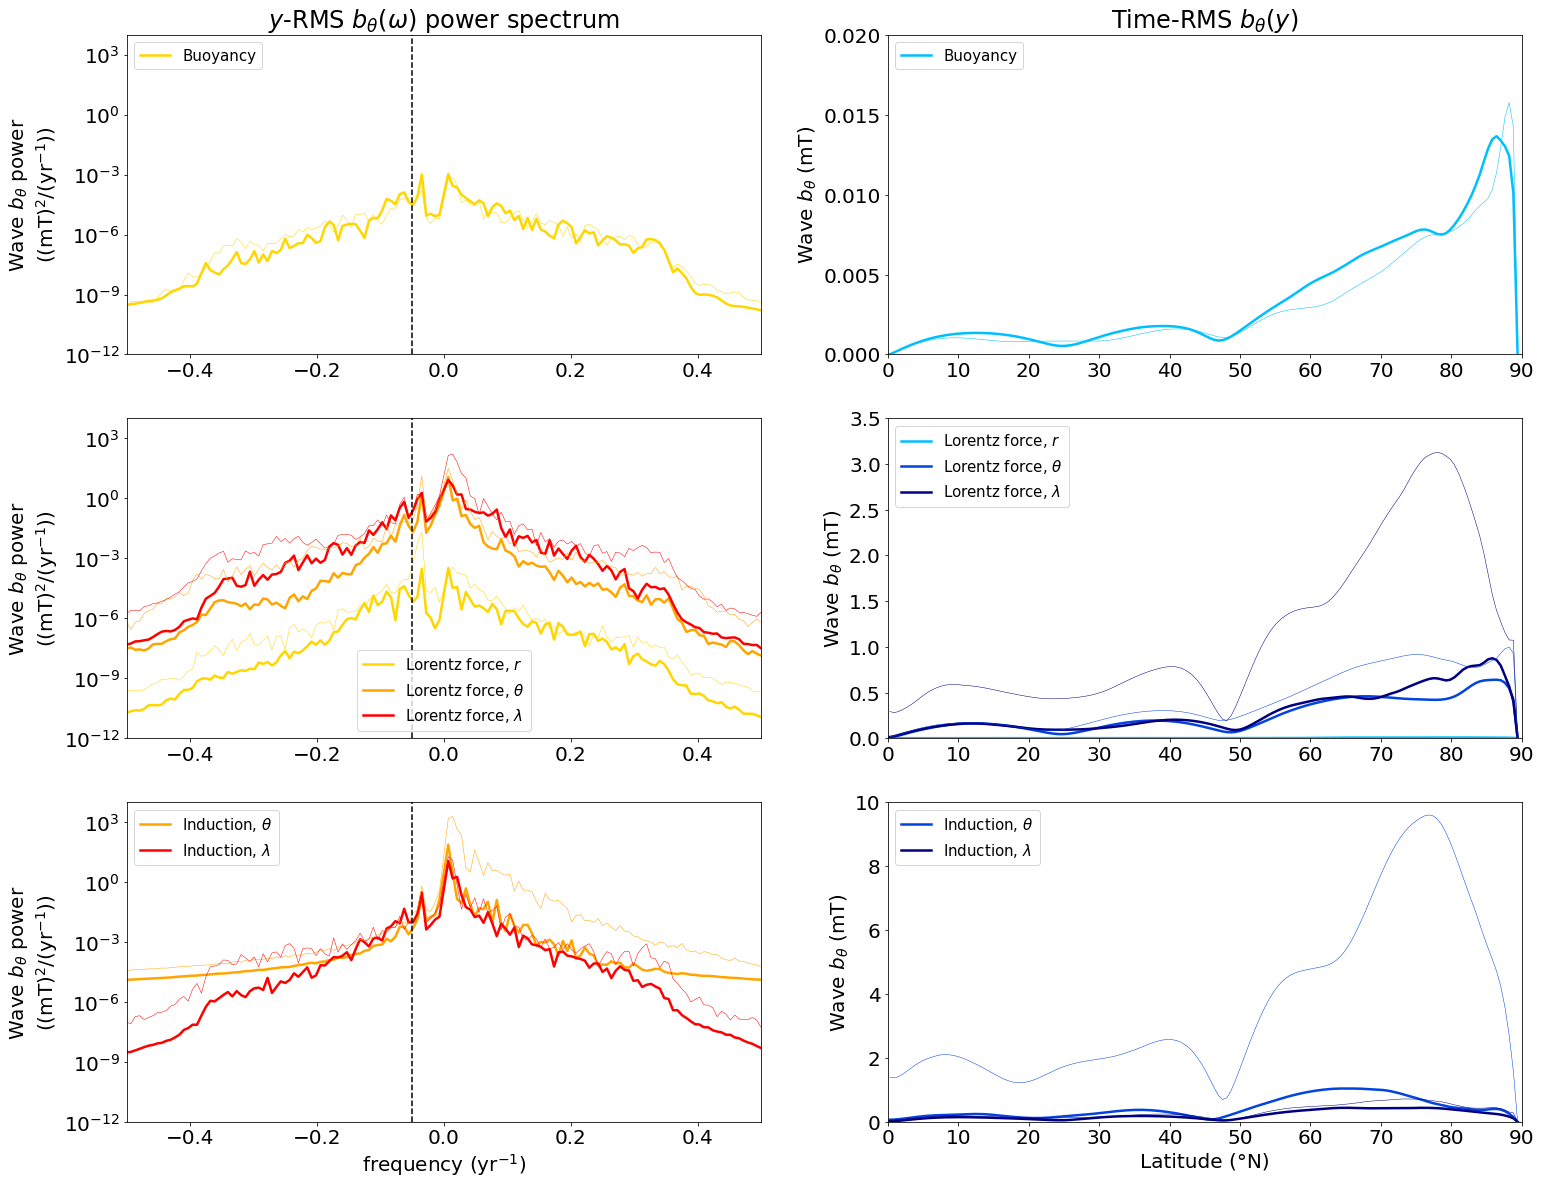

In [25]:
# Excited waves
matplotlib.rcParams.update({'font.size':20})
fig,axs=plt.subplots(3,2,figsize=(25,20))
lw1=2.5
lw2=0.5

# Buoyancy
(1e6/sectoyear*by_powspec_buoyancy_j1_hlat    ).plot(ax=axs[0,0],x='frequency_yr',color='gold',linewidth=lw1  ,label=r"Buoyancy"     )
(1e6/sectoyear*by_powspec_buoyancy_Pm2_j1_hlat    ).plot(ax=axs[0,0],x='frequency_yr',color='gold',linewidth=lw2)

(by_rms_buoyancy_j1    *1e3).plot(ax=axs[0,1],x='latitude',color='deepskyblue',linewidth=lw1,label=r"Buoyancy"     )
(by_rms_buoyancy_Pm2_j1    *1e3).plot(ax=axs[0,1],x='latitude',color='deepskyblue',linewidth=lw2    )


# Lorentz
(1e6/sectoyear*by_powspec_lorentz_r_j1_hlat    ).plot(ax=axs[1,0],x='frequency_yr',color='gold'  ,linewidth=lw1,label=r"Lorentz force, $r$"     )
(1e6/sectoyear*by_powspec_lorentz_theta_j1_hlat).plot(ax=axs[1,0],x='frequency_yr',color='orange',linewidth=lw1,label=r"Lorentz force, $\theta$")
(1e6/sectoyear*by_powspec_lorentz_lambda_j1_hlat  ).plot(ax=axs[1,0],x='frequency_yr',color='r'     ,linewidth=lw1,label=r"Lorentz force, $\lambda$"  )
(1e6/sectoyear*by_powspec_lorentz_Pm2_r_j1_hlat    ).plot(ax=axs[1,0],x='frequency_yr',color='gold'  ,linewidth=lw2)
(1e6/sectoyear*by_powspec_lorentz_Pm2_theta_j1_hlat).plot(ax=axs[1,0],x='frequency_yr',color='orange',linewidth=lw2)
(1e6/sectoyear*by_powspec_lorentz_Pm2_lambda_j1_hlat  ).plot(ax=axs[1,0],x='frequency_yr',color='r'     ,linewidth=lw2)

(by_rms_lorentz_r_j1    *1e3).plot(ax=axs[1,1],x='latitude',color='deepskyblue',linewidth=lw1,label=r"Lorentz force, $r$"     )
(by_rms_lorentz_theta_j1*1e3).plot(ax=axs[1,1],x='latitude',color='xkcd:blue'      ,linewidth=lw1,label=r"Lorentz force, $\theta$")
(by_rms_lorentz_lambda_j1  *1e3).plot(ax=axs[1,1],x='latitude',color='navy'      ,linewidth=lw1,label=r"Lorentz force, $\lambda$"  )
(by_rms_lorentz_Pm2_r_j1    *1e3).plot(ax=axs[1,1],x='latitude',color='deepskyblue',linewidth=lw2)
(by_rms_lorentz_Pm2_theta_j1*1e3).plot(ax=axs[1,1],x='latitude',color='xkcd:blue'      ,linewidth=lw2)
(by_rms_lorentz_Pm2_lambda_j1  *1e3).plot(ax=axs[1,1],x='latitude',color='navy'      ,linewidth=lw2)
   
# Induction
(1e6/sectoyear*by_powspec_induction_theta_j1_hlat).plot(ax=axs[2,0],x='frequency_yr',color='orange',linewidth=lw1,label=r"Induction, $\theta$")
(1e6/sectoyear*by_powspec_induction_lambda_j1_hlat  ).plot(ax=axs[2,0],x='frequency_yr',color='r'     ,linewidth=lw1,label=r"Induction, $\lambda$"  )
(1e6/sectoyear*by_powspec_induction_Pm2_theta_j1_hlat).plot(ax=axs[2,0],x='frequency_yr',color='orange',linewidth=lw2)
(1e6/sectoyear*by_powspec_induction_Pm2_lambda_j1_hlat  ).plot(ax=axs[2,0],x='frequency_yr',color='r'     ,linewidth=lw2)
 
(by_rms_induction_theta_j1*1e3).plot(ax=axs[2,1],x='latitude',color='xkcd:blue',linewidth=lw1,label=r"Induction, $\theta$")
(by_rms_induction_lambda_j1  *1e3).plot(ax=axs[2,1],x='latitude',color='navy',linewidth=lw1,label=r"Induction, $\lambda$"  )
(by_rms_induction_Pm2_theta_j1*1e3).plot(ax=axs[2,1],x='latitude',color='xkcd:blue',linewidth=lw2)
(by_rms_induction_Pm2_lambda_j1  *1e3).plot(ax=axs[2,1],x='latitude',color='navy',linewidth=lw2)


axs[2,0].set_xlabel(r'frequency (yr$^{-1}$)')
axs[2,1].set_xlabel('Latitude (°N)')
    

for ax in axs[:,0]:    
    ax.set_yscale('log')
    ax.set_ylabel(r'Wave $b_\theta$ power' '\n' '((mT)$^2$/(yr$^{-1}$))')
    ax.set_xlim(-0.5,0.5)
    ax.axvline(-0.05,color='k',linestyle='--')
    ax.set_ylim(1e-12,1e4)
    ax.legend(loc=2,fontsize=15)
for ax in axs[:,1]:   
    ax.set_ylabel(r'Wave $b_\theta$ (mT)')
    ax.legend(loc=2,fontsize=15)
for ax in axs[:-1].reshape(-1):
    ax.set_xlabel('')
    ax.set_title('')

axs[0,1].set_ylim(0.,2e-2); axs[0,1].set_xlim(0,90)
axs[1,1].set_ylim(0.,3.5)   ; axs[1,1].set_xlim(0,90)   
axs[2,1].set_ylim(0.,10)   ; axs[2,1].set_xlim(0,90)  

axs[1,0].legend(loc=8,fontsize=15)

axs[0,1].set_title(r"Time-RMS $b_\theta(y)$",fontsize=24)
axs[0,0].set_title(r"$y$-RMS $b_\theta(\omega)$ power spectrum",fontsize=24)

fig.savefig('figures/computedWaves.eps', format='eps',bbox_inches='tight')

# SA amplitude estimates

We first integrate the amplitude of forced waves over a small interval around the 20-year frequency of interest.

This yields an characteristic amplitude for the meridional perturbation carried by high-latitude waves at this frequency.

In [26]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, highlat avg b_theta - buoyancy = %.1e mT"%(1e3*np.sqrt(by_powspec_buoyancy_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - Lorentz theta= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_theta_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - Lorentz lambda= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_lambda_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - induction theta= %.1e mT"%(1e3*np.sqrt(by_powspec_induction_theta_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - induction lambda= %.1e mT"%(1e3*np.sqrt(by_powspec_induction_lambda_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))


RMS, highlat avg b_theta - buoyancy = 4.6e-04 mT
RMS, highlat avg b_theta - Lorentz theta= 1.2e-02 mT
RMS, highlat avg b_theta - Lorentz lambda= 4.2e-02 mT
RMS, highlat avg b_theta - induction theta= 5.8e-03 mT
RMS, highlat avg b_theta - induction lambda= 8.2e-03 mT


In [27]:
print(np.sqrt(4.2**2+1.2**2)*1e-5)
print(np.sqrt(5.8**2+8.2**2)*1e-6)

4.368065933568311e-05
1.0043903623591775e-05


In [28]:
freqindex_m20 = period_to_freqindex(-20*sectoyear)
deltafreq = (nonzero_frequencies()[1]-nonzero_frequencies()[0])
print("RMS, highlat avg b_theta - buoyancy = %.1e mT"%(1e3*np.sqrt(by_powspec_buoyancy_Pm2_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - Lorentz theta= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_Pm2_theta_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - Lorentz lambda= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_Pm2_lambda_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - induction theta= %.1e mT"%(1e3*np.sqrt(by_powspec_induction_Pm2_theta_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - induction lambda= %.1e mT"%(1e3*np.sqrt(by_powspec_induction_Pm2_lambda_j1_hlat.sel(frequency=1/(-20*sectoyear),method='nearest')*deltafreq)))


RMS, highlat avg b_theta - buoyancy = 7.2e-04 mT
RMS, highlat avg b_theta - Lorentz theta= 2.4e-02 mT
RMS, highlat avg b_theta - Lorentz lambda= 4.3e-02 mT
RMS, highlat avg b_theta - induction theta= 1.4e-02 mT
RMS, highlat avg b_theta - induction lambda= 9.6e-03 mT


In [29]:
print(np.sqrt(4.3**2+2.4**2)/np.sqrt(4.2**2+1.2**2))
print(np.sqrt(14**2+9.6**2)/np.sqrt(5.8**2+8.2**2))

1.127370551587632
1.6901074298707646


We now compute the estimates of secular acceleration amplitude, given in section 4.3 of the paper.

Given a meridional magnetic perturbation $\tilde b_\theta$, we integrate the induction equation, which in the Fourier space reads $$\partial_r(B_r \tilde v_\theta) = -i\omega\chi \tilde b_\theta$$

If the velocity perturbation is zero at the base of the layer (or below a small skin depth), and if we denote by $k$ the radial wavenumber ($k = j\pi/H$, such that the radial structure of $b_\theta$ is given by $\sin(kz)$), then $$\tilde v_\theta = \dfrac{i \omega\chi \tilde b_\theta}{k B_r}$$

We then use equation (35) of the manuscript to relate this flow amplitude estimate to an SA estimate:
$$\ddot b_r \simeq \nabla_H \cdot (\dot{\mathbf{v}}_H B_r) \simeq \dot v_\theta B_r / L_B$$

$B_r / L_B$ is estimated considering that the observed radial fiels varies by about 1 mT over 45° longitude at 70°N.

In [30]:
def bref_to_brddot(param,b_ref):
    """Given a characteristic amplitude of MAC wave meridional magnetic perturbation, compute the 
    corresponding secular acceleration signature (See equation 35 of Nicolas & Buffett, 2023).
    
    Parameters
    ----------
    param       : Param object
        Contains model parameters (e.g. spatial scales, rotation rate, stratification strength, etc.).


    Returns
    -------
    RMS_b        : xarray.DataArray
        RMS meridional structure of the forced waves (in terms of a meridional magnetic perturbation)

    """
    omega_ref = 2*np.pi/(-20*sectoyear)
    k = np.pi/param.H
    chi = 1 +1j*k**2/omega_ref*param.eta
    
    v_ref = 1j*omega_ref*chi*b_ref/(k*param.Br) #See scaling formula from induction eqn
    vdot_ref = 1j*omega_ref*v_ref
    
    gradBr_ref = 1e-3/(np.pi/4*6400e3*np.cos(70*np.pi/180))
    
    print("br_ddot = %.4f \mu T/yr^2"%(np.abs(vdot_ref)*gradBr_ref*1e6*sectoyear**2))
    

In [31]:
bref_to_brddot(param,4.6e-7)

br_ddot = 0.0024 \mu T/yr^2


In [32]:
bref_to_brddot(param,np.sqrt(4.2**2+1.2**2)*1e-5)

br_ddot = 0.2237 \mu T/yr^2


In [33]:
bref_to_brddot(param,np.sqrt(5.8**2+8.2**2)*1e-6)

br_ddot = 0.0514 \mu T/yr^2


In [34]:
bref_to_brddot(param,7.2e-7)

br_ddot = 0.0037 \mu T/yr^2


In [35]:
bref_to_brddot(param,np.sqrt(2.4**2+4.3**2)*1e-5)

br_ddot = 0.2522 \mu T/yr^2


In [36]:
bref_to_brddot(param,np.sqrt(14**2+9.6*2)*1e-6)

br_ddot = 0.0751 \mu T/yr^2


In [37]:
print("RMS, highlat avg b_theta - Lorentz theta= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_theta_j1_hlat.sel(frequency=1/(-31*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - Lorentz lambda= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_lambda_j1_hlat.sel(frequency=1/(-31*sectoyear),method='nearest')*deltafreq)))


RMS, highlat avg b_theta - Lorentz theta= 1.1e-01 mT
RMS, highlat avg b_theta - Lorentz lambda= 1.1e-01 mT


In [38]:
bref_to_brddot(param,np.sqrt(11**2+11**2)*1e-5)

br_ddot = 0.7966 \mu T/yr^2


In [39]:
print("RMS, highlat avg b_theta - Lorentz theta= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_theta_j1_hlat.sel(frequency=1/(-10*sectoyear),method='nearest')*deltafreq)))
print("RMS, highlat avg b_theta - Lorentz lambda= %.1e mT"%(1e3*np.sqrt(by_powspec_lorentz_lambda_j1_hlat.sel(frequency=1/(-10*sectoyear),method='nearest')*deltafreq)))


RMS, highlat avg b_theta - Lorentz theta= 6.0e-03 mT
RMS, highlat avg b_theta - Lorentz lambda= 2.1e-02 mT


In [40]:
bref_to_brddot(param,np.sqrt(21**2+6**2)*1e-6)

br_ddot = 0.1118 \mu T/yr^2
